<a href="https://colab.research.google.com/github/hessikaveh/VHbbPytorch/blob/master/vhbb_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive



## 1.1 Visualise the data

Let's generate the data and visualise it below. Darker reds correspond to higher values of z.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

## 1.2 Classifier definition

Let's define a basic Classifier class. It will be used in both the normal and the adversarial training.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
    """
    Basic classifier class
    
    Args:
        width (int): number of nodes in each layer
    """
    
    def __init__(self, width, n_inputs=2):
        super(Classifier, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(n_inputs, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = torch.sigmoid(self.output(x))
    
        return x


## 1.3 Standard (non-adversarial) classifier training and evaluation

Let's first train a vanilla classifier and see how it performs.

### Training block

Training block is written as a function in order to emphasize similarities between the toy and the physics example. All that will be different is the function which generates X, Y, and Z.

In [0]:
def normal_training(generating_function, N_train=500):
    
    # determine the size of hte classifier
    X, _, _, _ = generating_function(10)
    n_inputs = X.shape[1]
    
    # create the network and the optimiser
    clf = Classifier(10, n_inputs=n_inputs)
    optimiser = torch.optim.Adam(clf.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # track the losses
    clf_losses = []
    clf_losses_test = []

    for _ in range(N_train):

        # create the data
        X, Y, Z, weights = generating_function(512)
        X = torch.as_tensor(X, dtype=torch.float)
        Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float)
        Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float)
        weights = torch.as_tensor(weights.reshape(-1, 1), dtype=torch.float)

        # make the training loss
        output = clf(X)
        loss = criterion(output, Y)
        clf_losses.append(loss.data.numpy().item())

        # backprop
        clf.zero_grad()
        loss.backward()
        optimiser.step()
        
        # test loss
        X_test, Y_test, _ , weights_test= generating_function(512, train=False)
        X_test = torch.as_tensor(X_test, dtype=torch.float)
        Y_test = torch.as_tensor(Y_test.reshape(-1, 1), dtype=torch.float)
        output_test = clf(X_test)
        loss_test = criterion(output_test, Y_test) 
        clf_losses_test.append(loss_test.data.numpy().item())
    
    print('Done with training')

    fig, ax = plt.subplots()
    ax.plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax.plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax.set_xlabel('Training step')
    ax.set_ylabel('Classifier loss')
    ax.legend(loc='best')
    plt.show()
    
    return clf

#clf_toys = normal_training(generate_toys)

### Evaluation


Lots of plotting code, no need to read, just look at the figures on the bottom.

-----

The first panel shows the variates as above, with darker reds meaning higher Z values.

The second panel shows the classifier output as a surface over the 2D input plane.

The third panel shows the ROC curves for examples generated at Z=-1, 0, and 1. It is clear that separation is easier for higher values of Z.

The fourth panel shows the classifier output distribution for examples at Z=-1, 0, and 1. Similarly, the distribution of Z=1 examples is shifted to the right.

In [0]:
from sklearn.metrics import roc_curve

def show_roc_curves(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X0, Y0, Z0 = generate(n_samples, z=0)
    X1, Y1, Z1 = generate(n_samples, z=1)
    X_1, Y_1, Z_1 = generate(n_samples, z=-1)

    # compute the roc curves
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float))
    fpr0, tpr0, _ = roc_curve(Y0, Y0_pred.data)

    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    fpr1, tpr1, _ = roc_curve(Y1, Y1_pred.data)

    Y_1_pred = clf(torch.as_tensor(X_1, dtype=torch.float))
    fpr_1, tpr_1, _ = roc_curve(Y_1, Y_1_pred.data)

    # draw the roc curves
    ax.plot(fpr_1, tpr_1, c='yellow', label='Z=-1')
    ax.plot(fpr0, tpr0, c='red', label='Z=0')
    ax.plot(fpr1, tpr1, c='darkred', label='Z=1')

    # cosmetics
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')

def show_clf_output(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X0, Y0, Z0 = generate(n_samples, z=0)
    X1, Y1, Z1 = generate(n_samples, z=1)
    X_1, Y_1, Z_1 = generate(n_samples, z=-1)

    # compute the predictions
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float)) 
    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    Y_1_pred = clf(torch.as_tensor(X_1, dtype=torch.float))

    # show them
    bins = 30
    ax.hist(Y1_pred.data.numpy(), bins=bins, density=True, color='darkred', histtype='step', label='Z=1')
    ax.hist(Y0_pred.data.numpy(), bins=bins, density=True, color='red', histtype='step', label='Z=0')
    ax.hist(Y_1_pred.data.numpy(), bins=bins, density=True, color='yellow', histtype='step', label='Z=-1')

    # cosmetics
    ax.legend(loc='best')
    ax.set_title('Classifier output')
    ax.set_xlabel('Classifier output f(X|Z=z)')

def show_decision_boundary(ax, clf, generate):

    # generate test data
    n_samples = 100000
    X, Y, Z = generate(n_samples)

    # predict
    preds = clf(torch.as_tensor(X, dtype=torch.float)).data.numpy()

    # plot
    dec = ax.tricontourf(X[:,0], X[:,1], preds.ravel(), 20, extend='both')
    plt.colorbar(dec, ax=ax)

    # cosmetics
    ax.set_ylim(-1, 3)
    ax.set_xlim(-1, 2)
    ax.set_title('Decision boundary')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

def evaluate_classifier(clf, generate):

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    show_variates(ax[0, 0], generate)
    show_decision_boundary(ax[0, 1], clf, generate)
    show_roc_curves(ax[1,0], clf, generate)
    show_clf_output(ax[1,1], clf, generate)
    plt.show()
    
#evaluate_classifier(clf_toys, generate_toys)

## 1.4 Adversarial training of the classifier

Let's now train the same classifier with it's loss function modified by the adversary. 

### Adversary definition

In this simple example the adversary is a regression NN. It is used to predict the protected parameter Z from the classifier output.

In [0]:
class Regressor(nn.Module):
    """
    Basic regressor class. Can (and will) be used as the adversary in the
    training of the classifier.
    
    Args:
        width (int): number of nodes in each layer
    """
    
    def __init__(self, width):
        super(Regressor, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(1, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = self.output(x)
    
        return x



### Classifier training with the adversary

Train the classifier adversarially. Make sure you understand the code in this block.

In [0]:
def adversarial_training(generating_function, N_train=200):
    
    # determine the size of hte classifier
    X, _, _,_ = generating_function(10)
    n_inputs = X.shape[1]
    
    # create the classifier and the adversary networks
    clf = Classifier(10, n_inputs=n_inputs)
    adv = Regressor(10)

    # training settings
    learning_rate = 0.001
    lam = 10.0 # lambda tradeoff parameter

    # choose the criterions
    clf_criterion = nn.BCELoss()
    adv_criterion = nn.MSELoss()

    # create optimisers (larger learning rate for the adversary )
    clf_optimiser = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    adv_optimiser = torch.optim.Adam(adv.parameters(), lr=10*learning_rate)

    # keep track of the losses
    clf_losses = []
    adv_losses = []
    clf_losses_test = []
    adv_losses_test = []

    # training loop
    for _ in range(N_train):

        # create the data
        X, Y, Z, weights = generating_function(512)
        X = torch.as_tensor(X, dtype=torch.float)
        Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float)
        Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float)
        weights = torch.as_tensor(weights.reshape(-1, 1), dtype=torch.float)
        ##############################
        # Update the adversary network
        ##############################
        M=10
        for i in range(M):
          # make the adversary loss
          clf_output = clf(X)
          adv_output = adv(clf_output)
          adv_loss = adv_criterion(adv_output, Z)
          adv_losses.append(adv_loss.data.numpy().item())

          # backprop: adapt the adversary to the classifier (only update the adversary weights)
          adv.zero_grad()
          adv_loss.backward()
          adv_optimiser.step()

        ##############################
        # Update the classifier network
        ##############################
    

        # forward pass
        clf_output = clf(X)
        adv_output = adv(clf_output)
    
        # make the losses: both the classifier and the adversary loss
        # combined loss: note the minus sign!
        # (when updating the classifier, the goal is to confuse the adversary)
        clf_loss = clf_criterion(clf_output, Y)
        clf_loss = weights * clf_loss
        adv_loss = adv_criterion(adv_output, Z)
        adv_loss = weights * adv_loss
        comb_loss = torch.mean(clf_loss - lam * adv_loss)
            
        # backprop the classifier: update only the classifier weights (keep adversary intact)
        clf.zero_grad()
        comb_loss.backward()
        clf_optimiser.step()
            
        #clf_losses.append(clf_loss.data.numpy().item())
    
        #######################
        # store the test losses
        #######################
        X_test, Y_test, _,weights_test = generating_function(512, train=False)
        X_test = torch.as_tensor(X_test, dtype=torch.float)
        Y_test = torch.as_tensor(Y_test.reshape(-1, 1), dtype=torch.float)
        output_test = clf(X_test)
        loss_test = clf_criterion(output_test, Y_test)
        clf_losses_test.append(loss_test.data.numpy().item())
    
    print('Done with training')

    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax[0].plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax[0].set_ylabel('Classifier loss')
    ax[0].legend(loc='best')
    ax[1].plot(range(len(adv_losses)), adv_losses, color='k')
    ax[1].set_ylabel('Adversary loss')
    ax[1].set_xlabel('Training step')
    plt.show()
    
    return clf


#clf_toys_adv = adversarial_training(generate_toys, 300)
#evaluate_classifier(clf_toys_adv, generate_toys)

# 2 Physics example

Here we look at a physically interesting situation: Search for a Standard Model Higgs boson produced in association with a vector boson decaying to a pair of bottom quarks (VH->bb). While there are several backgrounds in the real analysis we will focus on just one, Z+jets.

The goal of the classification task is to separate H->bb events from the Z+jets background without learning the mass of the di-b-jet system.

-----

Thanks to Philipp Windischhofer for producing and sharing these MadGraph samples!

## 2.1 Visualise the data

### Get the data

This will download ~12MB, will hopefully take no more than a minute.

In [0]:
    # ------------------------------------------
    # load pickled numpy arrays or HDF5 as input data
    # ------------------------------------------
    def unpickle(fileName):
        # pickled and gzipped numpy arrays
        if fileName.endswith('.dmpz') or fileName.endswith('.dmp'):
            inputFile = gzip.open(fileName,'rb') if fileName.endswith('.dmpz') else open(fileName, "rb")
            try:
                data = pickle.load(inputFile, encoding='latin1')
            except:
                data = pickle.load(inputFile)
            inputFile.close()
        # HDF5 (smaller, recommended)
        elif fileName.endswith('.h5') or fileName.endswith('.hdf5'):
            data = {}
            with h5py.File(fileName, "r") as f:
                for k in ['meta', 'category_labels']:
                    data[k] = dict(json.loads(f.attrs[k].decode('utf-8'))) #py3 no .decode('utf-8') needed
                for k in ['train', 'test']:
                    data[k] = {k2: f.get(k + '/' + k2).value for k2 in ['X', 'y']}
                    #optional: 'sample_weight', 'sample_weight_error'
                    try:
                        data[k]['sample_weight'] = f.get(k + '/sample_weight').value
                    except:
                        data[k]['sample_weight'] = np.full(len(data[k]['y']), 1.0, dtype=np.float32)
                    try:
                        data[k]['sample_weight_error'] = f.get(k + '/sample_weight_error').value
                    except:
                        data[k]['sample_weight_error'] = np.full(len(data[k]['y']), 0.0, dtype=np.float32)

                try:
                    for k in ['data']:
                        data[k] = {k2: f.get(k + '/' + k2).value for k2 in ['X']}
                    print("INFO: DATA included in H5 file, can make DATA/MC plots!")
                except:
                    pass

        # print meta data
        if 'meta' in data:
            print("INFO: read inputs from disk, metadata is pesent:")
            for k in sorted(data['meta'].keys()):
                print("INFO:  >  ",k,data['meta'][k])
        return data


In [0]:
#!pip install h5py

In [10]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import h5py
import json
import numpy as np
# download the data
"""if not 'MadGraph.pkl' in os.listdir():
    print('Downloading data:')
    !wget http://www-pnp.physics.ox.ac.uk/~zgubic/Hbb/MadGraph.pkl -O MadGraph.pkl
else:
    print('Data already downloaded')
    print(os.listdir())"""
    
# prepare the data


#df = pd.read_pickle('MadGraph.pkl')
#features = ['MET', 'pTB1', 'pTB2', 'dRBB', 'dEtaBB', 'dPhiMETdijet']
#X = df[features]
#Y = df[['Y']]
all_features = ['H_mass_fit_fallback', 'H_pt_fit_fallback', 'V_pt', 'nAddJets_2lep', 'SA5', 'V_mass', 'MET_Pt', 'hJets_leadingPt', 'hJets_subleadingPt', 'jjVPtRatio', 'HJ1_HJ2_dEta', 'HVdPhi_fit_fallback', 'hJets_btagged_0', 'hJets_btagged_1', 'HJ1_HJ2_dR', 'n_recoil_jets_fit', 'H_mass_sigma_fit']
features = ['H_pt_fit_fallback', 'V_pt', 'nAddJets_2lep', 'SA5', 'V_mass', 'MET_Pt', 'hJets_leadingPt', 'hJets_subleadingPt', 'jjVPtRatio', 'HJ1_HJ2_dEta', 'HVdPhi_fit_fallback', 'hJets_btagged_0', 'hJets_btagged_1', 'HJ1_HJ2_dR', 'n_recoil_jets_fit', 'H_mass_sigma_fit']
data = unpickle("/content/drive/My Drive/vhbb/data_withCompleteCuts.h5")
X_train = data['train']['X']
Y_train = data['train']['y']
sample_weight_train = data['train']['sample_weight']
sample_weight_train = pd.DataFrame(sample_weight_train, columns=['weight'])
X_train = pd.DataFrame(X_train, columns=all_features)
Y_train = pd.DataFrame(Y_train, columns=['Y'])
Z_train = X_train[['H_mass_fit_fallback']]

X_test = data['test']['X']
Y_test = data['test']['y']
sample_weight_test = data['test']['sample_weight']
sample_weight_test = pd.DataFrame(sample_weight_test, columns=['weight'])
X_test = pd.DataFrame(X_test, columns=all_features)
Y_test = pd.DataFrame(Y_test, columns=['Y'])
Z_test = X_test[['H_mass_fit_fallback']]

del X_test['H_mass_fit_fallback']
del X_train['H_mass_fit_fallback']

#print(Z)
# preprocessing
X = pd.concat([X_train, X_test],axis=0, join='inner')
Y = pd.concat([Y_train, Y_test],axis=0, join='inner')
Z = pd.concat([Z_train, Z_test],axis=0, join='inner')
X_pca = PCA(X.shape[1], svd_solver='auto', whiten=True)
Z_pca = PCA(Z.shape[1], svd_solver='auto', whiten=True)

X_pca.fit(X)
Z_pca.fit(Z)
df = pd.concat([X, Y],axis=1, join='inner')
print (df.head())
# split
#X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y, Z)

def generate_hbb(n_samples, train=True):
    
    # test or train
    X_full = X_train if train else X_test
    Y_full = Y_train if train else Y_test
    Z_full = Z_train if train else Z_test
    weights_full = sample_weight_train if train else sample_weight_test
    # sample the events
    random_state = np.random.randint(0, 10000)
    X = X_full.sample(n_samples, random_state=random_state)
    Y = Y_full.sample(n_samples, random_state=random_state)
    Z = Z_full.sample(n_samples, random_state=random_state)
    weights = weights_full.sample(n_samples, random_state=random_state)
    # preprocess them
    return X_pca.transform(X), Y.values, Z_pca.transform(Z), weights.values
    #return X.values, Y.values, Z.values
X, Y, Z, weights = generate_hbb(10000, train=True)


INFO: read inputs from disk, metadata is pesent:
INFO:  >   variables H_mass_fit_fallback H_pt_fit_fallback V_pt nAddJets_2lep SA5 V_mass MET_Pt hJets_leadingPt hJets_subleadingPt jjVPtRatio HJ1_HJ2_dEta HVdPhi_fit_fallback hJets_btagged_0 hJets_btagged_1 HJ1_HJ2_dR n_recoil_jets_fit H_mass_sigma_fit
   H_pt_fit_fallback        V_pt  ...  H_mass_sigma_fit    Y
0         227.006790  229.563721  ...         17.820295  1.0
1         153.907333  154.488251  ...         10.239766  1.0
2         155.563187  190.107605  ...         11.275752  1.0
3          18.904070  201.898819  ...          0.397262  1.0
4         169.643005  168.136353  ...         19.277073  1.0

[5 rows x 17 columns]


### Show the data

Here, let's take a look at a few kinematic variables for the signal and background samples.

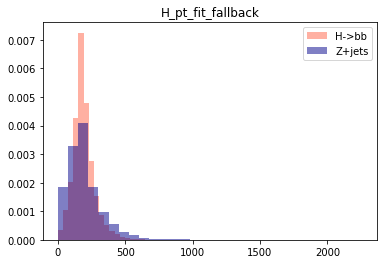

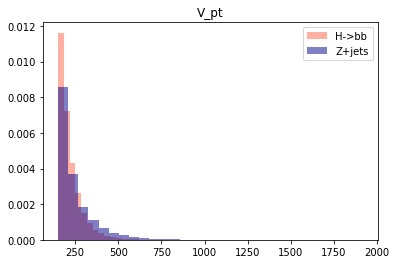

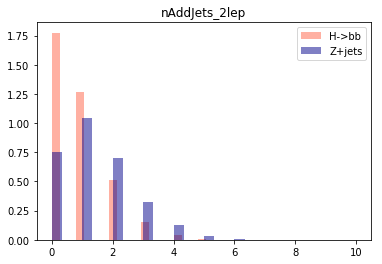

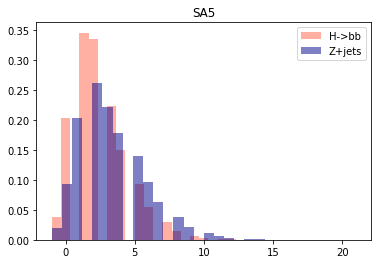

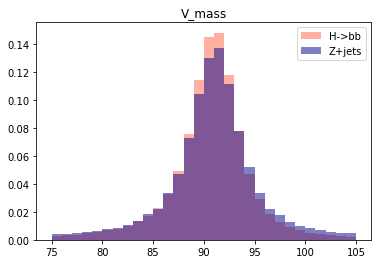

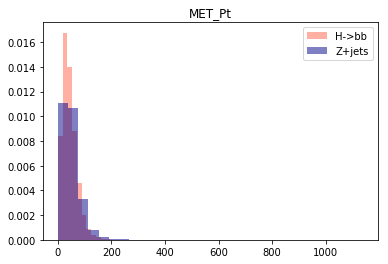

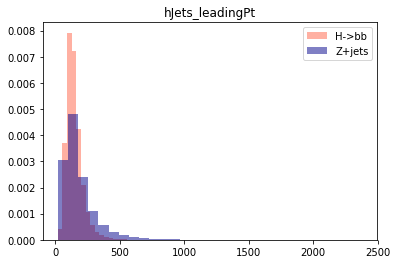

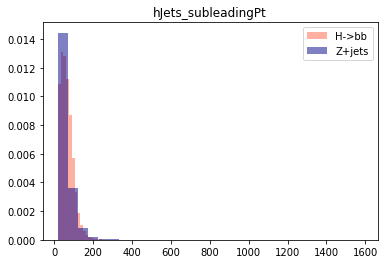

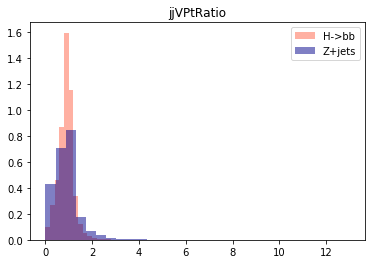

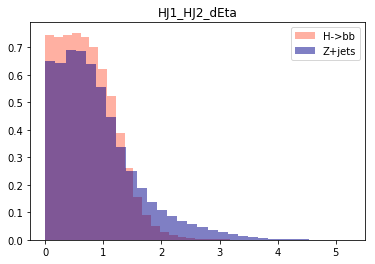

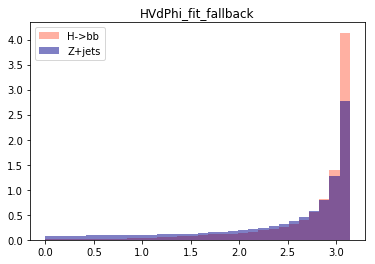

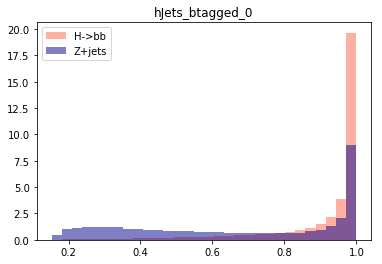

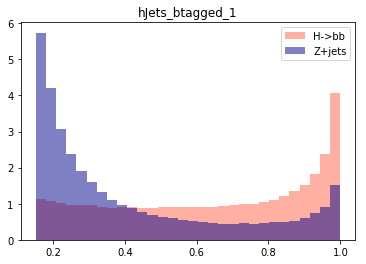

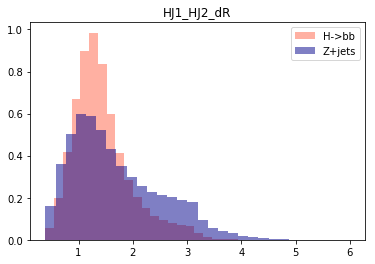

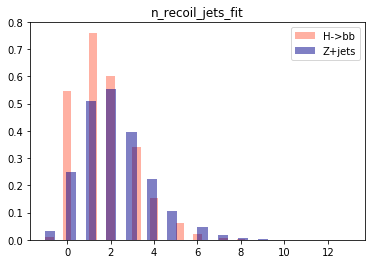

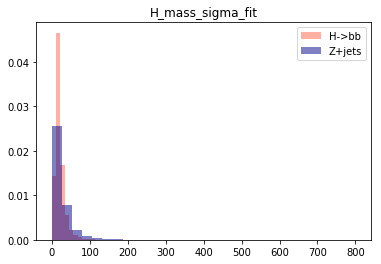

In [11]:
for feature in features:
    fig, ax = plt.subplots()
    _ = ax.hist(df.query('Y==1')[feature], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb')
    _ = ax.hist(df.query('Y==0')[feature], bins=30, alpha=0.5, density=True, color='darkblue', label='Z+jets')
    ax.set_title(feature)
    ax.legend(loc='best')

## 2.2 Normal training

**Using Keras**

In [65]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input
inputs = Input(shape=(X_train.shape[1], )) # placeholder

hidden = Dense(10, activation='relu')(inputs)
hidden = Dropout(0.2)(hidden)
hidden = Dense(20, activation='relu')(hidden)
hidden = Dropout(0.2)(hidden)
hidden = Dense(30, activation='relu')(hidden)
hidden = Dropout(0.2)(hidden)
outputs = Dense(2, activation='softmax')(hidden)
# last layer has to have the same dimensionality as the number of classes we want to predict, here 3

model = Model(inputs, outputs)
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                170       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                220       
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 30)                630       
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
__________

In [66]:
from keras.utils.vis_utils import plot_model
plot_model(model, 'temp.png', show_shapes=True)

model.compile('adam', 'sparse_categorical_crossentropy')
 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
print( Counter(Y_test) )
# uneven classes

print('Training:')
try:
    model.fit(
        X_train, Y_train,
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
        epochs=10, 
        validation_split = 0.2,
        verbose=True
) 
except KeyboardInterrupt:
    print( 'Training ended early.' )
# -- load in best network
model.load_weights('tutorial-progress.h5')

# -- Save network weights and structure
print( 'Saving model...' )
model.save_weights('tutorial.h5', overwrite=True)
json_string = model.to_json()
open('tutorial.json', 'w').write(json_string)
print( 'Done' )

print( 'Testing...' )
yhat = model.predict(X_test, verbose = True, batch_size = 512) 

# predictions
print(yhat)

Counter({'Y': 1})
Training:
Train on 258553 samples, validate on 64639 samples
Epoch 1/10
258553/258553 [==============================] - 15s 57us/step - loss: 0.1317 - val_loss: 4.2911

Epoch 00001: val_loss improved from inf to 4.29105, saving model to tutorial-progress.h5
Epoch 2/10
258553/258553 [==============================] - 14s 55us/step - loss: 0.0960 - val_loss: 4.0467

Epoch 00002: val_loss improved from 4.29105 to 4.04675, saving model to tutorial-progress.h5
Epoch 3/10
258553/258553 [==============================] - 14s 54us/step - loss: 0.0952 - val_loss: 3.9161

Epoch 00003: val_loss improved from 4.04675 to 3.91607, saving model to tutorial-progress.h5
Epoch 4/10
258553/258553 [==============================] - 14s 54us/step - loss: 0.0945 - val_loss: 3.8892

Epoch 00004: val_loss improved from 3.91607 to 3.88923, saving model to tutorial-progress.h5
Epoch 5/10
258553/258553 [==============================] - 14s 53us/step - loss: 0.0943 - val_loss: 4.0881

Epoch 00

[0.06 0.05 0.07 ... 0.08 0.04 0.02]
[0.94 0.95 0.93 ... 0.92 0.96 0.98]


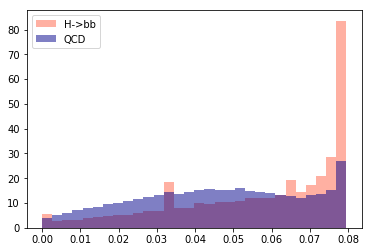

In [70]:
# -- turn them into classes
yhat_cls = np.argmax(yhat, axis=1)

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("confusion.png")

print(yhat[:,0])
print(yhat[:,1])
weights = pd.concat([sample_weight_test, Y_test], axis=1)
yhat_df = pd.DataFrame(yhat)
yhat_pred = pd.concat([yhat_df, Y_test], axis=1)
#print(weights[weights['Y']==1]['weight'], yhat_pred)
# Compute confusion matrix
#cnf_matrix = confusion_matrix(Y_test, yhat, sample_weight=sample_weight_test)
#cnf_matrix = confusion_matrix(Y_test, yhat_cls)
#np.set_printoptions(precision=2)
#plot_confusion_matrix(cnf_matrix, classes=['Hbb', 'Bkg'],
#                      normalize=True,
#                      title='Normalized confusion matrix')
# signal eff = weighted tpr --> out of all signal events, what % for we classify as signal?
#print ('Signal efficiency:', sample_weight_test[(yhat == 0)].sum() / sample_weight_test[yhat == 0].sum())

# bkg eff = weighted fpr --> out of all bkg events, what % do we classify as signal?
b_eff = weights[(Y_test != 0) ].sum() / weights[Y_test != 0].sum()
#print ('Background efficiency:', b_eff)
#print ('Background rej:', 1 / b_eff)
fig, ax = plt.subplots()
_ = ax.hist(yhat_pred[yhat_pred['Y']==0][0], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb', weights =[ weights[weights['Y']==0]['weight'] ])
_ = ax.hist(yhat_pred[yhat_pred['Y']==1][0], bins=30, alpha=0.5, density=True, color='darkblue', label='QCD', weights =[ weights[weights['Y']==1]['weight'] ])
ax.legend()

### Training

Done with training


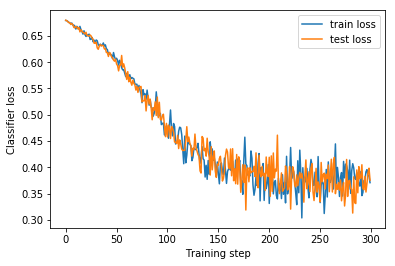

In [0]:
clf_hbb = normal_training(generate_hbb, 300)

### Evaluation

Lots of plotting code first, just look at the figures at the bottom.

It can be seen that the classifier learns the mass of the two b-quarks to be a powerful discriminating variable: it preferentially selects events around the Higgs boson mass.

In [0]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def show_roc_curves_hbb(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X, Y, Z, weights = generate(n_samples)
    
    # split events in the three mass ranges
    low_z = Z_pca.transform([[115]])
    high_z = Z_pca.transform([[125]])
    mask_1 = (Z < low_z).ravel()
    X_1 = X[mask_1]
    Y_1 = Y[mask_1]
    mask1 = (Z > high_z).ravel()
    X1 = X[mask1]
    Y1 = Y[mask1]
    mask0 = ((Z > low_z) & (Z < high_z)).ravel()
    X0 = X[mask0]
    Y0 = Y[mask0]
    
    # compute the roc curves
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float))
    fpr0, tpr0, _ = roc_curve(Y0, Y0_pred.data)

    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    fpr1, tpr1, _ = roc_curve(Y1, Y1_pred.data)

    Y_1_pred = clf(torch.as_tensor(X_1, dtype=torch.float))
    fpr_1, tpr_1, _ = roc_curve(Y_1, Y_1_pred.data)

    # draw the roc curves
    ax.plot(fpr_1, tpr_1, c='yellow', label='mBB < 115 GeV')
    ax.plot(fpr0, tpr0, c='red', label='115 < mBB < 125 GeV')
    ax.plot(fpr1, tpr1, c='darkred', label='mBB > 125 GeV')

    # cosmetics
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')

def show_mass_distribution(ax, clf, generate):
    
    # generate test data
    n_samples = 10000
    X, Y, Z, weights = generate(n_samples)
    
    # split events depending on the score they get
    Y_pred = clf(torch.as_tensor(X, dtype=torch.float)).detach().numpy()
    median = np.percentile(Y_pred, 50)
    #median = 0.88
    # get the mass shape
    mass = Z_pca.inverse_transform(Z)
    
    # plot stacked 
    ax.hist([mass[(Y==0) & (Y_pred>median)],mass[(Y==0) & (Y_pred<median)],   mass[(Y==1) & (Y_pred>median)], mass[(Y==1) & (Y_pred<median)] ]
            , bins=30,stacked=True, range=(50, 200), alpha=0.5, label=[ 'bkg high score', 'bkg low score','H->bb high score', 'H->bb low score'],
             weights=[ weights[(Y==0) & (Y_pred>median)], weights[(Y==0) & (Y_pred<median)] , weights[(Y==1) & (Y_pred>median)],weights[(Y==1) & (Y_pred<median)] ])
    # plot inclusive spectra, and spectra with high and low scores
    #ax.hist(mass[Y==1], bins=30, range=(50, 200), alpha=0.5, label='H->bb', color='tomato', weights=weights[Y==1])
    #ax.hist(mass[(Y==1) & (Y_pred>median)], bins=30, range=(50, 200), histtype='step', color='tomato', weights=weights[(Y==1) & (Y_pred>median)])
    #ax.hist(mass[(Y==1) & (Y_pred<median)], bins=30, range=(50, 200), histtype='step', color='tomato', linestyle=':', weights=weights[(Y==1) & (Y_pred<median)])
    
    #ax.hist(mass[Y==0], bins=30, range=(50, 200), alpha=0.5, label='Z+jets', color='darkblue', weights=weights[Y==0])
    #ax.hist(mass[(Y==0) & (Y_pred>median)], bins=30, range=(50, 200), histtype='step', color='darkblue', weights=weights[(Y==0) & (Y_pred>median)])
    #ax.hist(mass[(Y==0) & (Y_pred<median)], bins=30, range=(50, 200), histtype='step', color='darkblue', linestyle=':', weights=weights[(Y==0) & (Y_pred<median)])
    

    custom_lines = [Patch(facecolor='tomato', alpha=0.5),
                    Line2D([0], [0], color='tomato'),
                    Line2D([0], [0], color='tomato', linestyle=':'),
                    Patch(facecolor='darkblue', alpha=0.5),
                    Line2D([0], [0], color='darkblue'),
                    Line2D([0], [0], color='darkblue', linestyle=':'),
                   ]

    #ax.legend(custom_lines, ['H->bb inclusive', 'H->bb high score', 'H->bb low score',
    #                         'bkg inclusive', 'bkg high score', 'bkg low score'])
    ax.legend()
def show_discriminator_distribution(ax, clf, generate):
    
    # generate test data
    n_samples = 10000
    X, Y, Z, weights = generate(n_samples)
    
    # split events depending on the score they get
    Y_pred = clf(torch.as_tensor(X, dtype=torch.float)).detach().numpy()
    median = np.percentile(Y_pred, 50)
    #median = 0.88
    # get the mass shape
    mass = Z_pca.inverse_transform(Z)
    print(median)
    # plot stacked 
    #ax.hist([Y_pred[Y==0],Y_pred[(Y==0) & (Y_pred>median)],Y_pred[(Y==0) & (Y_pred<median)],   Y_pred[(Y==1) & (Y_pred>median)], Y_pred[(Y==1) & (Y_pred<median)] ]
    #        , bins=30,stacked=True, range=(0, 1), alpha=0.5, label=['bkg inclusive', 'bkg high score', 'bkg low score','H->bb high score', 'H->bb low score'])
#
    ax.hist([Y_pred[(Y==0) & (Y_pred>median)],Y_pred[(Y==0) & (Y_pred<median)],  Y_pred[(Y==1) & (Y_pred>median)], Y_pred[(Y==1) & (Y_pred<median)] ]
            , bins=30,stacked=True, range=(0, 1), alpha=0.5, label=['bkg high score', 'bkg low score','H->bb high score', 'H->bb low score'],
             weights=[ weights[(Y==0) & (Y_pred>median)], weights[(Y==0) & (Y_pred<median)] ,weights[(Y==1) & (Y_pred>median)],weights[(Y==1) & (Y_pred<median)] ])
    # plot inclusive spectra, and spectra with high and low scores
    #ax.hist(mass[Y==1], bins=30, range=(50, 200), alpha=0.5, label='H->bb', color='tomato', weights=weights[Y==1])
    #ax.hist(mass[(Y==1) & (Y_pred>median)], bins=30, range=(50, 200), histtype='step', color='tomato', weights=weights[(Y==1) & (Y_pred>median)])
    #ax.hist(mass[(Y==1) & (Y_pred<median)], bins=30, range=(50, 200), histtype='step', color='tomato', linestyle=':', weights=weights[(Y==1) & (Y_pred<median)])
    
    #ax.hist(mass[Y==0], bins=30, range=(50, 200), alpha=0.5, label='Z+jets', color='darkblue', weights=weights[Y==0])
    #ax.hist(mass[(Y==0) & (Y_pred>median)], bins=30, range=(50, 200), histtype='step', color='darkblue', weights=weights[(Y==0) & (Y_pred>median)])
    #ax.hist(mass[(Y==0) & (Y_pred<median)], bins=30, range=(50, 200), histtype='step', color='darkblue', linestyle=':', weights=weights[(Y==0) & (Y_pred<median)])
    

    custom_lines = [Patch(facecolor='tomato', alpha=0.5),
                    Line2D([0], [0], color='tomato'),
                    Line2D([0], [0], color='tomato', linestyle=':'),
                    Patch(facecolor='darkblue', alpha=0.5),
                    Line2D([0], [0], color='darkblue'),
                    Line2D([0], [0], color='darkblue', linestyle=':'),
                   ]

    #ax.legend(custom_lines, ['H->bb inclusive', 'H->bb high score', 'H->bb low score',
    #                         'bkg inclusive', 'bkg high score', 'bkg low score'])
    ax.legend()

def evaluate_hbb_classifier(clf, generate):

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    show_roc_curves_hbb(ax[0], clf, generate_hbb)
    #show_mass_distribution(ax[1], clf, generate_hbb)
    #show_discriminator_distribution(ax[1], clf, generate_hbb)
    plt.show()
def evaluate_hbb_classifier2(clf, generate):

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    #show_roc_curves_hbb(ax[0], clf, generate_hbb)
    show_mass_distribution(ax[0], clf, generate_hbb)
    show_discriminator_distribution(ax[1], clf, generate_hbb)
    plt.show()
#evaluate_hbb_classifier(clf_hbb, generate_hbb)
#evaluate_hbb_classifier2(clf_hbb, generate_hbb)

## 2.3 Adversarial training

### Easy Task

Now, a very short task for you! The key is to note that the adversarial training proceeds in exactly the same way as before, only with a different dataset. 

Task: Reuse the functions above to train your own adversarial classifier.



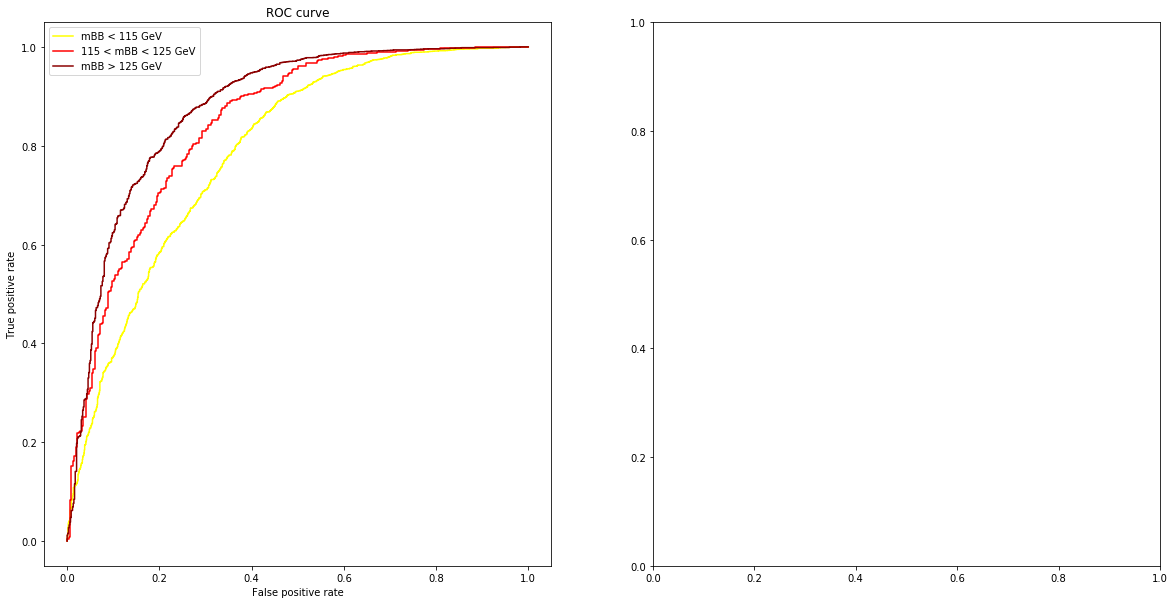

0.885121077299118


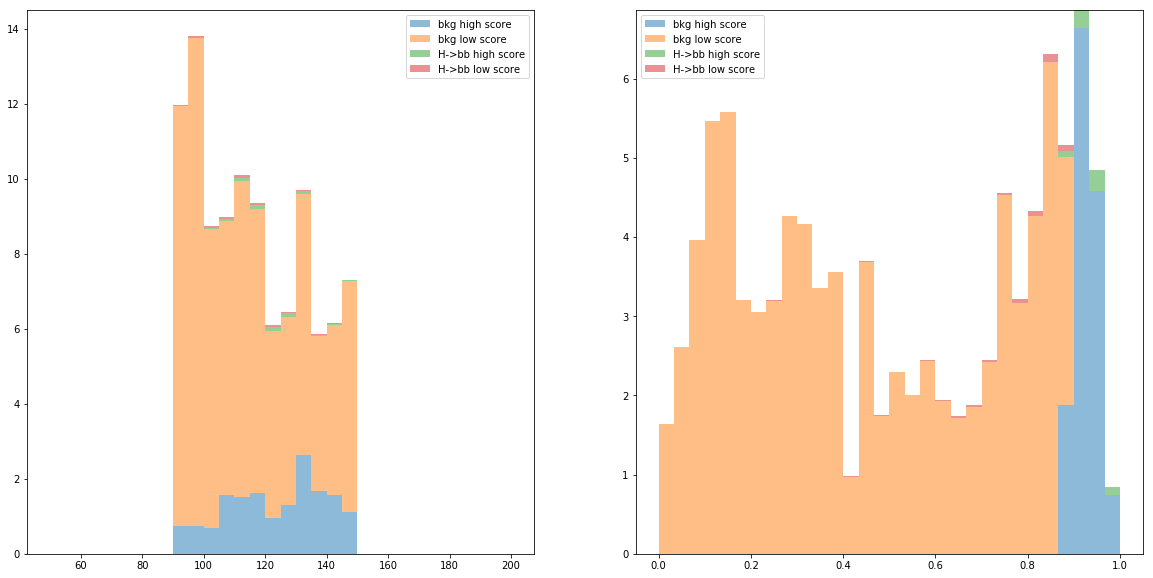

In [0]:

#
# train the classifier here:
#clf_hbb_adv = adversarial_training(generate_hbb, 500)
#
# evaluate the classifier here:
evaluate_hbb_classifier(clf_hbb_adv, generate_hbb)
evaluate_hbb_classifier2(clf_hbb_adv, generate_hbb)

#
#




### Solutions

In [0]:
# <your code here>
#
# train the classifier here:
#clf_hbb_adv = adversarial_training(generate_hbb, 1000)
#
# evaluate the classifier here:
#evaluate_hbb_classifier(clf_hbb_adv, generate_hbb)
#
#


[[ -7.18324938e-01  -9.37319453e-02  -4.33532730e-01 ...,  -3.73920080e-01
    9.00609107e-01  -5.54203240e-02]
 [ -2.07246706e-01  -4.05823543e-01   3.34690052e-01 ...,  -3.35971757e-01
   -4.94077614e-01   3.83492083e-01]
 [ -6.92974258e-01  -4.95139407e-01   6.90971519e-01 ...,  -8.63815442e-04
    2.57517566e-01  -5.79368278e-02]
 ..., 
 [ -4.02587301e-01  -3.23610896e-01  -3.17287530e-01 ...,   1.02772498e+00
   -4.19312946e-01   4.40817274e-01]
 [  4.27523148e-01   6.43243985e-01  -1.76001875e+00 ...,   8.15269769e-01
   -9.96470192e-02   1.86883272e-01]
 [ -8.76898394e-02  -1.80294849e-01  -9.16993766e-01 ...,  -1.76679848e-01
    6.79929772e-01  -4.16923623e-01]] [[ 1.]
 [ 1.]
 [ 0.]
 ..., 
 [ 1.]
 [ 1.]
 [ 1.]]


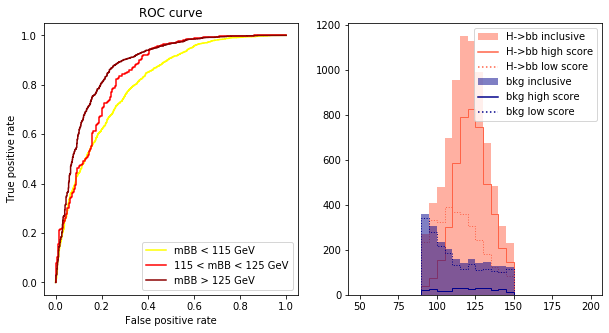

In [0]:
evaluate_hbb_classifier(clf_hbb_adv, generate_hbb)


### Harder task 1

Play around with the adversarial training parameters:

a) What happens if you increase the number of training steps? \\
b) How to get rid of the loss oscillations? Hint: is the task the adversary is trying to solve stationary? \\
c) Change classifier complexity: try a linear classifier, or increase the number of layers.



### Harder Task 2

If this is too easy, try using a different adversary:

  - Gaussian mixture model, as in the original paper [1] (Keras implementation at [2]), 
  
  or
 
  - Mutual Information Neural Estimator (MINE) [3] (Pytorch implementation at [4])

Gaussian mixture model essentially models the probability density distribution over the protected parameter Z, rather than a point estimate that we have used. The loss function is essentially a log likelihood.

MINE provides a differentiable estimate of the mutual information [5] between the output of the classifier and the protected parameter, allowing the classifier to change in a way which minimises it directly.


[1] https://arxiv.org/abs/1611.01046 \\
[2] https://github.com/glouppe/paper-learning-to-pivot/blob/master/code/Toy.ipynb \\
[3] https://arxiv.org/abs/1801.04062 \\
[4] https://github.com/MasanoriYamada/Mine_pytorch \\
[5] https://en.wikipedia.org/wiki/Mutual_information
